<a href="https://colab.research.google.com/github/BasilLeaf42/Photo-Unskewer/blob/main/ImageUnskewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow
from skimage import io
from skimage import color
from PIL import Image
import matplotlib.pylab as plt

# Compute homography
def computeH(im1_pts, im2_pts):
    points = im1_pts.shape[0]
    A = np.zeros((2 * points, 9))

    # Sort through points
    for i in range(points):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]

        A[2 * i + 0] = np.array([-x1, -y1, -1, 0, 0, 0, (x2 * x1), (x2 * y1), x2])
        A[2 * i + 1] = np.array([0, 0, 0, -x1, -y1, -1, (y2 * x1), (y2 * y1), y2])
    
    Vh = np.linalg.svd(A)[2]
    H = Vh[-1].reshape((3, 3))
    scaleFactor = H[2, 2]
    H = H / scaleFactor

    return H

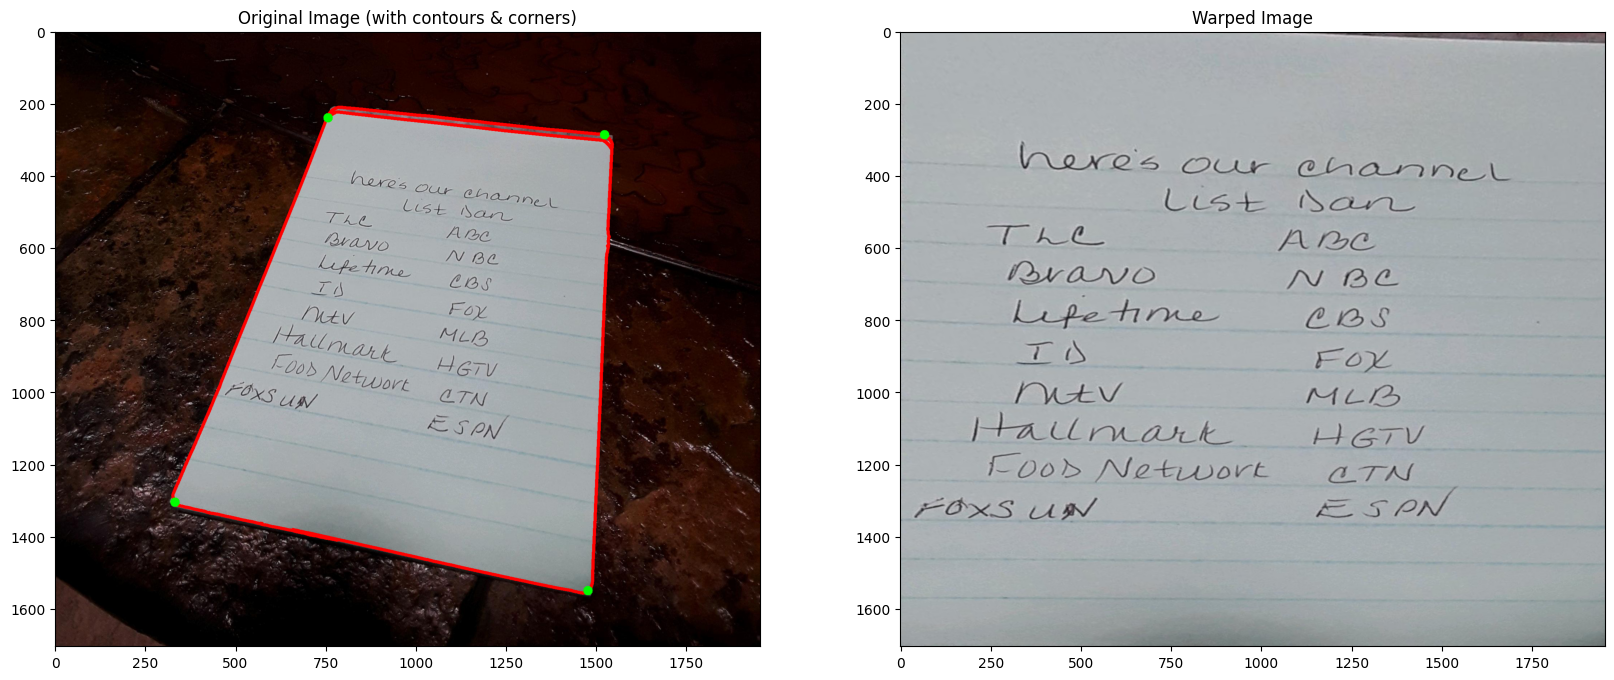


This program uses a median blur combined with Canny edge detection to find the edges and corners of the image.
From this, it will narrow down the corners to approximate what the "true corners" of the image would be.
This program works best when there is only one quadrilateral in the image.


In [6]:
# Import dependencies
import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow
from skimage import io
from skimage import color
from PIL import Image
import matplotlib.pylab as plt

# Import image
url = 'https://i.redd.it/bebi64i3kbb31.jpg'
imgBGR = io.imread(url)
img = cv.cvtColor(imgBGR, cv.COLOR_BGR2RGB)
height, width, channels = img.shape
imgCopy = img.copy()

# Filter image
imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
imgBlur = cv.medianBlur(imgGray, 49)
imgEdges = cv.Canny(imgBlur, 20, 200)
# cv2_imshow(imgEdges)

# Find contours
contours = cv.findContours(imgEdges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
imgContour = cv.drawContours(img, contours, -1, (0, 0, 255), 7)

# Find corners
corners = []
for contour in contours:
    approx = cv.approxPolyDP(contour, 0.1 * cv.arcLength(contour, True), True)
    # cv.drawContours(img, [approx], 0, (0, 255, 0), 3)

    for i in range(len(approx)):
        x, y = approx[i][0]
        corners.append([x, y])
        # cv.circle(img, (x, y), 5, (0, 255, 0), -1)

# print(corners)
# print(len(corners))
# cv2_imshow(imgContour)

# Keep points closest to image corners
# height = 1700
# width = 1950
corners = np.array(corners)

corner1Distance = np.linalg.norm(corners - [0, 0], axis = 1)
corner1 = corners[np.argmin(corner1Distance)]
cv.circle(img, corner1, 13, (0, 255, 0), -1)

corner2Distance = np.linalg.norm(corners - [0, 1700], axis = 1)
corner2 = corners[np.argmin(corner2Distance)]
cv.circle(img, corner2, 13, (0, 255, 0), -1)

corner3Distance = np.linalg.norm(corners - [1950, 1700], axis = 1)
corner3 = corners[np.argmin(corner3Distance)]
cv.circle(img, corner3, 13, (0, 255, 0), -1)

corner4Distance = np.linalg.norm(corners - [1950, 0], axis = 1)
corner4 = corners[np.argmin(corner4Distance)]
cv.circle(img, corner4, 13, (0, 255, 0), -1)

# Initialize coordinates
img1Points = np.vstack((corner1, corner2, corner3, corner4))
img2Points = np.array([[0, 0], [0, 1700], [1950, 1700], [1950, 0]])

#cv2_imshow(imgContour)

# Compute homography and warp image
H = computeH(img1Points, img2Points)
# DEBUGGING/TESTING ONLY
# H = cv.findHomography(img1Points, img2Points)[0]
imwarped = cv.warpPerspective(imgCopy, H, (1953, 1704))

# Display images
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[0].set_title('Original Image (with contours & corners)')
ax[1].imshow(cv.cvtColor(imwarped, cv.COLOR_BGR2RGB))
ax[1].set_title('Warped Image')
plt.show()

print('')
print('This program uses a median blur combined with Canny edge detection to find the edges and corners of the image.')
print('From this, it will narrow down the corners to approximate what the "true corners" of the image would be.')
print('This program works best when there is only one quadrilateral in the image.')